In [1]:
import dash, math, datetime as dt, pandas as pd
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template
import plotly.io as pio

%load_ext autoreload
%autoreload 2
import figures, main_etl, extract_data, transform_data

In [ ]:
# Seaborn colors  
# ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']    

## Dashboard com previsão de velocidade

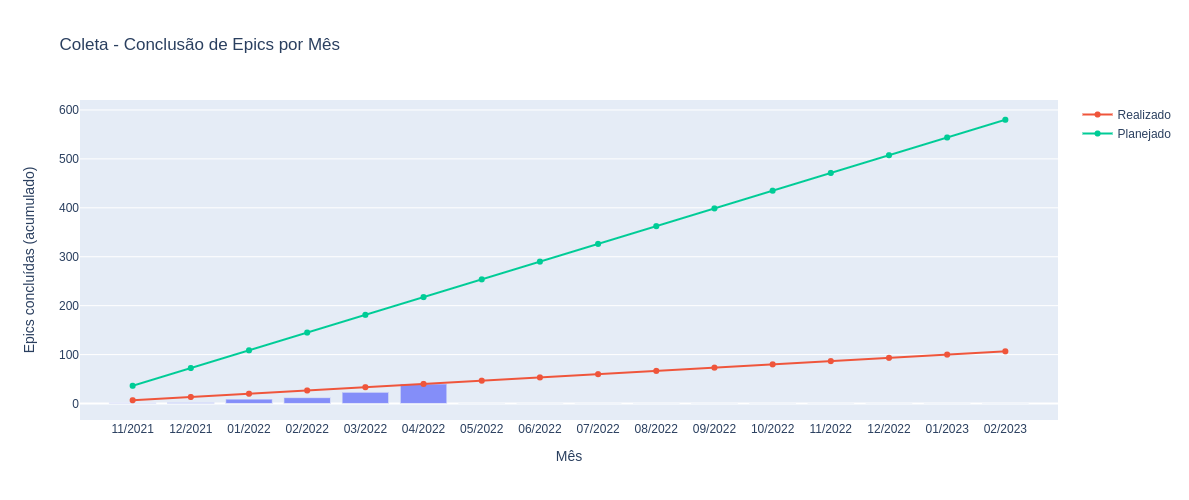

In [84]:
import plotly
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px

def plot_speed_epics(df, title):     
    
    # Medindo velocidade
    current_speed = df["closed"].mean()          
    df["closed_cumsum"] = df["closed"].cumsum()
    
    df = df.merge( pd.DataFrame(["11/2021", "12/2021"] + [f'{x:02d}/2022' for x in range(1,13)] + 
                                ["01/2023", "02/2023"], columns=["month"]), how="right").fillna(0)          
        
    ### baseado no Siplanweb: 29 coletores, 15 templates + 5 municipios
    total_epics = 29 * (15 + 5)    
    total_months = df.shape[0]
    ideal_speed = total_epics / total_months
    
    # Plot
    fig =  px.bar(df, x="month", y="closed_cumsum", title=title, opacity=0.75, height=500,
                 labels={"closed_cumsum":"Epics concluídas (acumulado)", "month":"Mês"})
    
    fig.update_layout(yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 100))
    fig.add_trace(go.Scatter(x=df.month, y=[i * current_speed for i in range(1, total_months+1)], 
                              name="Realizado", text=df))
    fig.add_trace(go.Scatter(x=df.month, y=[i * ideal_speed for i in range(1, total_months+1)], 
                              name="Planejado"))    
    
    return fig


count_epics_month_df = pd.read_csv("data/count_epics_month.csv")

plot_speed_epics(count_epics_month_df, title='Coleta - Conclusão de Epics por Mês')



## Dashboard Desenvolvimento

In [12]:
exigencias_df = pd.read_csv("data/exigencias_dev.csv", usecols=["tag","subtag"]).drop_duplicates()
exigencias_df

,tag,subtag
0,Acesso à Informação,Informações
7,Acesso à Informação,Requisitos Exigidos
12,Acesso à Informação,Bases de dados abertos
13,Acesso à Informação,Relatório estatístico
16,Informações institucionais,Estrutura organizacional
17,Informações institucionais,Unidades administrativas
20,Informações institucionais,Registro das competências
21,Informações institucionais,Link de acesso
22,Informações institucionais,Conselhos Municipais
23,Receitas,Dados das receitas


In [8]:
epics_dev_df = pd.read_csv("data/tmp.csv").drop(columns=['title', 'tag', 'subtag']).drop_duplicates(
    'template', ignore_index=True).dropna(subset=['template'])

epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.pivot(index="template", columns="title", values="state")

epics_dev_df[:] = 3

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

title,Acesso à Informação: Bases de dados abertos,Acesso à Informação: Informações,Acesso à Informação: Relatório estatístico,Acesso à Informação: Requisitos Exigidos,Concursos Públicos: Cópia do edital do concurso,Concursos Públicos: Dados do Concurso,Concursos Públicos: Divulgação,Contratos: Conteúdo integral,Contratos: Dados dos contratos,Contratos: Gerar relatório,...,Servidores Públicos: Dados de remuneração,Servidores Públicos: Dados dos servidores,Servidores Públicos: Dispêndios,Servidores Públicos: Proventos de aposentadoria,Servidores Públicos: Proventos de pensão,Servidores Públicos: Registro da remuneração,Servidores Públicos: Registro por lotação,Servidores Públicos: Relatório mensal,Terceiro Setor: Dados de Parcerias,Terceiro Setor: Repasses
template,,,,,,,,,,,,,,,,,,,,,
ABO,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Betha,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Fiorilli,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
GOVBR,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
GRP,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Habeas Data,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
IPM Sistemas,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Memory,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Municipal Net,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [15]:
epics_dev_df = pd.read_csv("data/top_templates.csv")

epics_dev_df = epics_dev_df[epics_dev_df['rank'] <= 15]
epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.drop(columns=['tag', 'subtag'])

y_label = "template_rank"
epics_dev_df[y_label] = epics_dev_df["template"] + " (" + epics_dev_df["rank"].astype(str) + "º)"
epics_dev_df = epics_dev_df.drop(columns=["template"])

epics_dev_df = epics_dev_df.pivot(index="template_rank", columns="title", values="rank")
epics_dev_df[:] = 4

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

title,Acesso à Informação: Bases de dados abertos,Acesso à Informação: Informações,Acesso à Informação: Relatório estatístico,Acesso à Informação: Requisitos Exigidos,Concursos Públicos: Cópia do edital do concurso,Concursos Públicos: Dados do Concurso,Concursos Públicos: Divulgação,Contratos: Conteúdo integral,Contratos: Dados dos contratos,Contratos: Gerar relatório,...,Servidores Públicos: Dados de remuneração,Servidores Públicos: Dados dos servidores,Servidores Públicos: Dispêndios,Servidores Públicos: Proventos de aposentadoria,Servidores Públicos: Proventos de pensão,Servidores Públicos: Registro da remuneração,Servidores Públicos: Registro por lotação,Servidores Públicos: Relatório mensal,Terceiro Setor: Dados de Parcerias,Terceiro Setor: Repasses
template_rank,,,,,,,,,,,,,,,,,,,,,
(m) Betim (3º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
(m) Juiz de Fora (2º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
(m) Teófilo Otoni (4º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
(m) Uberlândia (1º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
(m) Varginha (5º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
ABO (13º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
ADPM (12º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Betha (10º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
GRP (9º),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


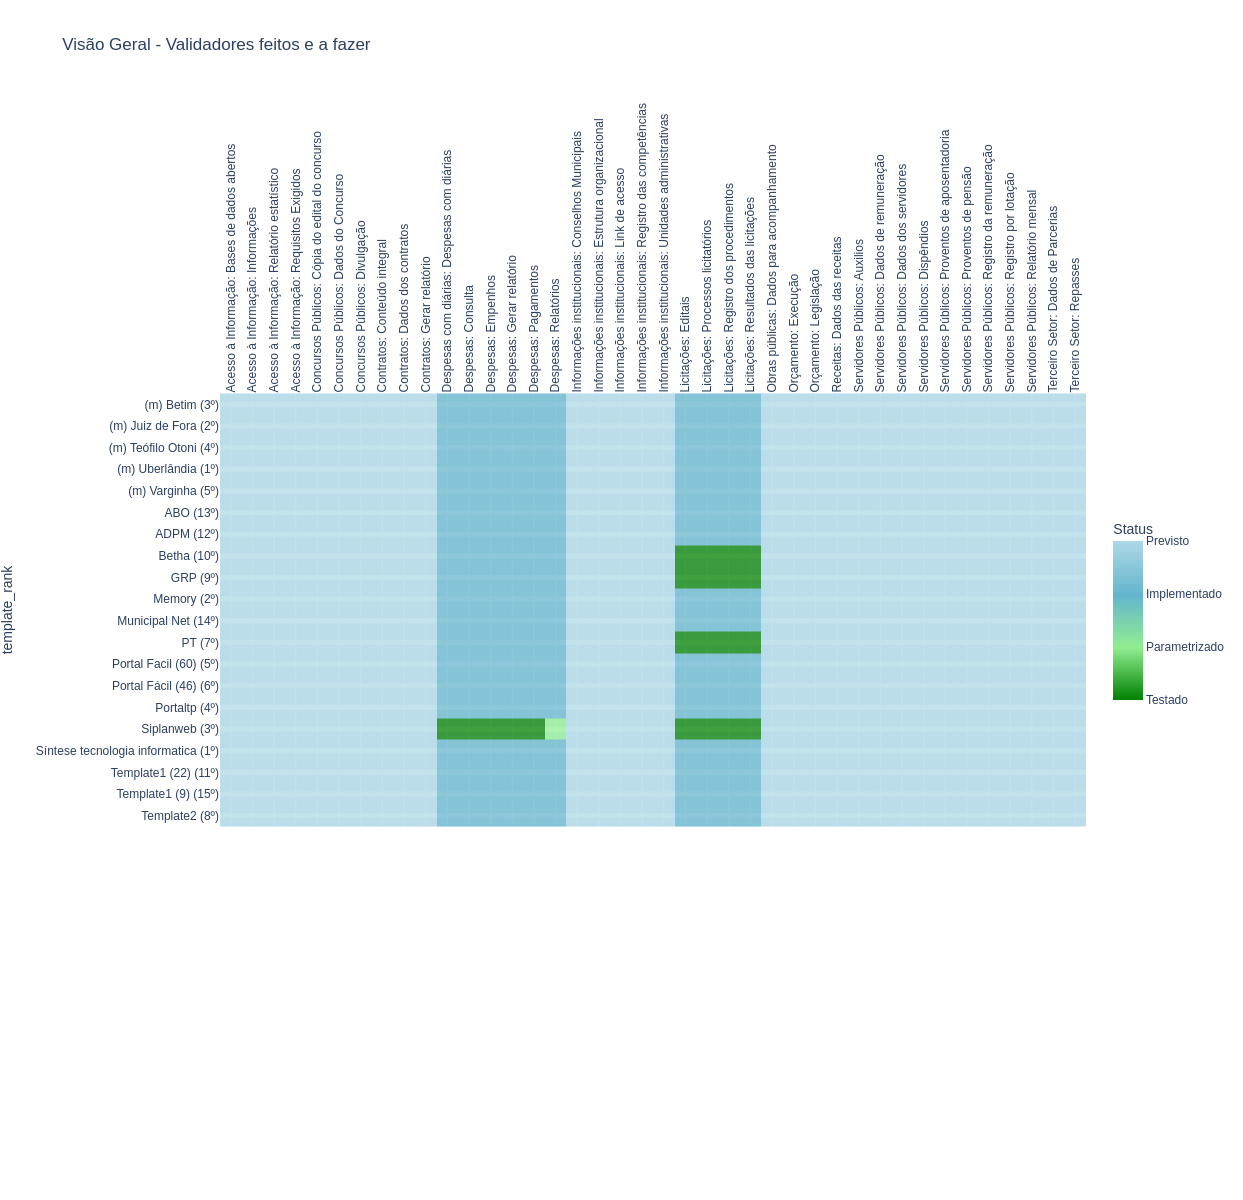

In [80]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_status_epics_dev(df, title, y_column, x_column, hue, showlegend=True):    

    fig = px.imshow(
        df, height=1200, title=title,
        color_continuous_scale=[(0, "green"), (0.33, 'lightgreen'), (0.66, "#64b5cd"), (1, 'lightblue')]
    )     
        
    fig.update_traces(opacity=0.75)
    fig.update_xaxes(tickangle=-90, side="top")
    fig.update_yaxes(showgrid=True, gridwidth=5)
    
    fig.update_layout(coloraxis_colorbar=dict(
        title="Status", 
        tickvals=[1,2,3,4],
        ticktext=["Testado","Parametrizado","Implementado",'Previsto'],
        lenmode="pixels", len=200        
    ))
    
    return fig


figures.plot_status_epics_dev = plot_status_epics_dev

epics_dev_df = pd.read_csv("data/epics_dev.csv", index_col="template_rank")

figures.plot_status_epics_dev(epics_dev_df, title='Visão Geral - Validadores feitos e a fazer',        
        y_column='template', x_column='title', hue="state", showlegend=True)


In [3]:
import seaborn as sns 
tips = sns.load_dataset('tips')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


## Coleta: Epics por Template

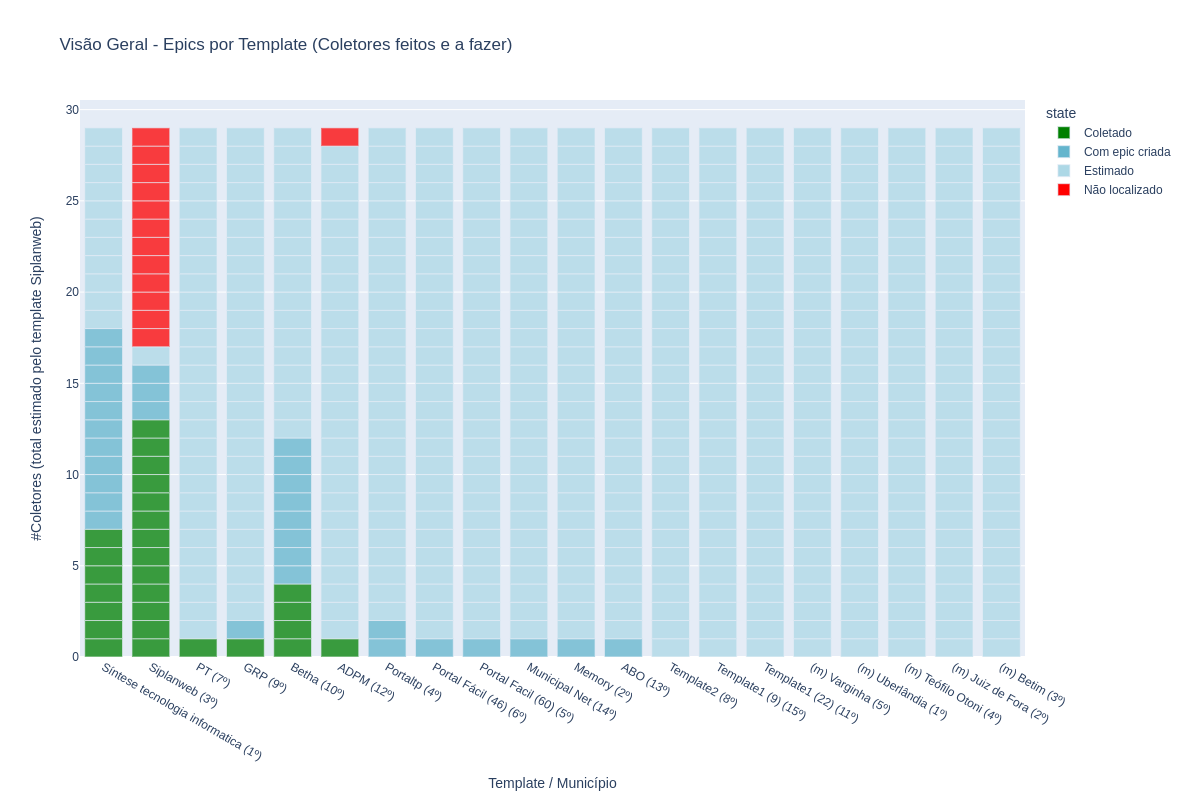

In [9]:
import plotly
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px

def plot_status_epics(df, top_templates_df, title='Visão Geral - Epics por Template (Coletores feitos e a fazer)'):
       
    count_col = 'aux'
    state_col = 'state'
    total = 29  # reference: Siplanweb    
    
    # Pre-process dataframes
    top_templates_df = top_templates_df[top_templates_df['rank'] <= 15]
    df = top_templates_df.merge(df, how='left').fillna({state_col:'Estimado', count_col:1})     
    templates = df['template'].dropna().unique()
    
    # Fill missing (estimated) epics in df
    for template in templates:        
        created =  df.groupby('template').count()[state_col][template]
        missing = total - created                
        rank = df[df.template == template]['rank'].values[0]        
        
        for i in range(missing):            
            df = df.append({'template':template, state_col:'Estimado', 'rank':rank,count_col:1}, ignore_index=True)    

    # Add a better name for x values
    x = "template_rank"
    df[x] = df["template"] + " (" + df["rank"].astype(str) + "º)"
    df = df.sort_values(by=[state_col, x], ascending=[True, False])
    
    # Plot
    fig = px.bar(
        df, y=count_col, x=x, color=state_col, height=800, width=1000, title=title,
        color_discrete_map = {"Coletado":"green", "Com epic criada":"#64b5cd", 'Estimado':'lightblue', "Não localizado":"red"}, 
        labels = {count_col:"#Coletores (total estimado pelo template Siplanweb)", x:"Template / Município"}, opacity=0.75 )    

    return fig


epics_df = pd.read_csv("data/epics.csv")
top_templates_df = pd.read_csv("data/top_templates.csv")

plot_status_epics(epics_df, top_templates_df)



In [8]:
epics_df.groupby(["template", "state"]).count()["aux"]

template                        state          
ABO                             Com epic criada     1
ADPM                            Coletado            1
                                Não localizado      1
Betha                           Coletado            4
                                Com epic criada     8
Fiorilli                        Coletado            1
                                Com epic criada     1
GOVBR                           Com epic criada     1
GRP                             Coletado            1
                                Com epic criada     1
Habeas Data                     Coletado            1
IPM Sistemas                    Com epic criada     1
Memory                          Com epic criada     1
Municipal Net                   Com epic criada     1
PT                              Coletado            1
Portal Facil (60)               Com epic criada     1
Portal Fácil (46)               Com epic criada     1
Portal fácil                    Co

In [74]:

# TODO completar issues sem labels (branco)

## Outros gráficos

In [1]:
import os
import spacy
from github import Github
from zenhub import Zenhub
import pandas as pd
import numpy as np

import plotly.graph_objects as go 

nlp = spacy.load('pt_core_news_sm')

repo_id='357557193'

In [2]:
import pickle
import dash
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template

import plotly
import plotly.figure_factory as ff
import plotly.io as pio

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None 

In [148]:
import extract_data
import transform_data
import figures

In [251]:
%load_ext autoreload
%autoreload 2

import main_etl
import app
import figures
import extract_data
import transform_data
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from github import Github
from zenhub import Zenhub

In [6]:
repo_id_f01='357557193'
git_token=<TOKEN>
zh_token=<TOKEN>

In [7]:
zh = Zenhub(zh_token)
g = Github(git_token)
    
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

In [355]:
main_etl.job()

In [205]:
def get_info_epics_by_id(epics_id, filter_data=False):
    
    data = {'title': [], 'id':[] , 'tag':[], 'template': [], 'status': []}

    for epic_id in epics_id:
    
        issue = repo_F01.get_issue(epic_id)
        labels = issue.labels
        labels = [i.name for i in labels]
    
        if 'generalization test' in labels or filter_data:

            data['title'].append(issue.title)
            data['id'].append(epic_id)
            data['tag'].append(extract_data.get_specific_labels(labels, pattern='tag'))
            data['template'].append(extract_data.get_specific_labels(labels, pattern='template'))
            data['status'].append(issue.state)
        
    df = pd.DataFrame(data)
    
    return df

In [184]:
def get_info_issues_by_id(ids):
    
    data = {'title': [], 'id':[], 'status': [], 'created_at':[], 'closed_at':[]}
    
    for issue_id in ids:
    
        issue = repo_F01.get_issue(issue_id)
    
        data['title'].append(issue.title)
        data['id'].append(issue_id)
        data['status'].append(issue.state)
        data['created_at'].append(issue.created_at)
        data['closed_at'].append(issue.closed_at)
        
    df = pd.DataFrame(data)
    
    return df

In [253]:
def main_job2():
    epics_id = extract_data.get_epics_ids(zh, repo_id_f01)
    epics_df = extract_data.get_info_filtered_issues(epics_id, repo_F01)

    epics_id_dev = list(epics_df['id'])
    issues_data = extract_data.get_data_epics(zh, epics_id_dev, repo_id_f01)
    epics_info = extract_data.get_epics_info(repo_F01, issues_data)
    epics_info_df = pd.DataFrame(epics_info).T.reset_index()

    exploded_df = epics_info_df.explode('issues').reset_index(drop=True)

    exploded_df = exploded_df.loc[~exploded_df['issues'].isna()]
    issues_id = exploded_df['issues'].tolist()

    info_issues_dev = extract_data.get_info_issues_by_id(issues_id, repo_F01)

    info_issues_dev.to_csv("data/info_issues_dev.csv", index=False)
    info_issues_dev = pd.read_csv("data/info_issues_dev.csv")

    info_issues_dev['closed_at'] = info_issues_dev['closed_at'].fillna(0)
    info_issues_dev = transform_data.format_date(info_issues_dev, time_column='closed_at', status='closed')
    info_issues_dev = transform_data.format_date(info_issues_dev, time_column='created_at', status='created')

    closed_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_closed', aggfunc='count').fillna(0).reset_index()
    closed_df.drop('1/1970', axis = 1,inplace=True)

    open_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_created', aggfunc='count').fillna(0).reset_index()

    columns_name = transform_data.sort_columns(open_df)
    open_df = open_df[columns_name]

    columns_name = transform_data.sort_columns(closed_df)
    closed_df = closed_df[columns_name]

    count_month_dev = transform_data.count_by_month(open_df, closed_df)

    df = info_issues_dev.merge(exploded_df, left_on='id', right_on='issues')
    df = df.groupby(['template','tag', 'status'])['status'].count().unstack().reset_index().fillna(0)
    df = df.sort_values('closed', ascending=False)

    count_month_dev.to_csv("data/count_month_dev.csv", index=False)
    open_df.to_csv("data/open_df_dev.csv", index=False)
    closed_df.to_csv("data/closed_df_dev.csv", index=False)
    df.to_csv("data/coletas_tag_dev.csv", index=False)

In [254]:
main_job2()

In [211]:
issues_id = exploded_df['issues'].tolist()

In [185]:
info_issues_dev = get_info_issues_by_id(issues_id)

In [256]:
info_issues_dev['week'] =  pd.to_datetime(info_issues_dev['closed_at']).dt.strftime('%W')
week_status = transform_data.count_by_week(info_issues_dev, column_to_group='week', time_column='closed_at')

In [259]:
week_status.to_csv("data/week_status_dev.csv", index=False)

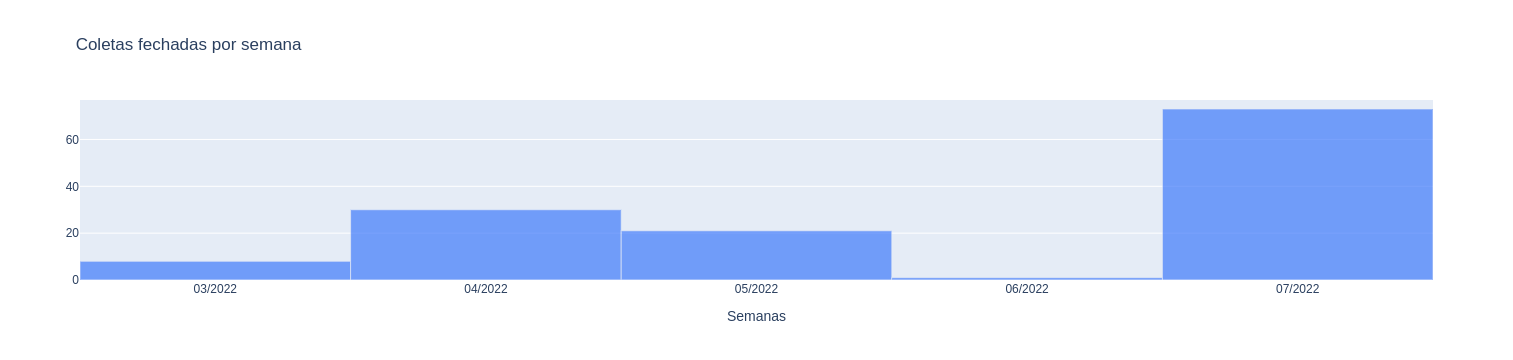

In [258]:
figures.plot_status_week(
        week_status, y_column='closed_at', x_column='week',
        title='Coletas fechadas por semana', xaxis_title_text='Semanas')

In [187]:
info_issues_dev.to_csv("data/info_issues_dev.csv", index=False)
info_issues_dev = pd.read_csv("data/info_issues_dev.csv")

In [188]:
info_issues_dev['closed_at'] = info_issues_dev['closed_at'].fillna(0)
info_issues_dev = transform_data.format_date(info_issues_dev, time_column='closed_at', status='closed')
info_issues_dev = transform_data.format_date(info_issues_dev, time_column='created_at', status='created')

In [189]:
closed_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_closed', aggfunc='count').fillna(0).reset_index()
closed_df.drop('1/1970', axis = 1,inplace=True)

open_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_created', aggfunc='count').fillna(0).reset_index()

In [190]:
columns_name = transform_data.sort_columns(open_df)
open_df = open_df[columns_name]

columns_name = transform_data.sort_columns(closed_df)
closed_df = closed_df[columns_name]

In [231]:
count_month_dev = transform_data.count_by_month(open_df, closed_df)

In [192]:
x = open_df.columns[1:].tolist()
z = open_df.columns[1:]
y = 'municipio'

closed_colum='closed'
open_colum='open'

fig1 = figures.plot_status_mes(
        count_month, x_column=x, name1='Issues de generalização abertas', name2="Issues de generalização fechadas",
        y1_column=open_colum, y2_column=closed_colum, title='Generalizações por mês')

In [232]:
count_month_dev.to_csv("data/count_month_dev.csv", index=False)

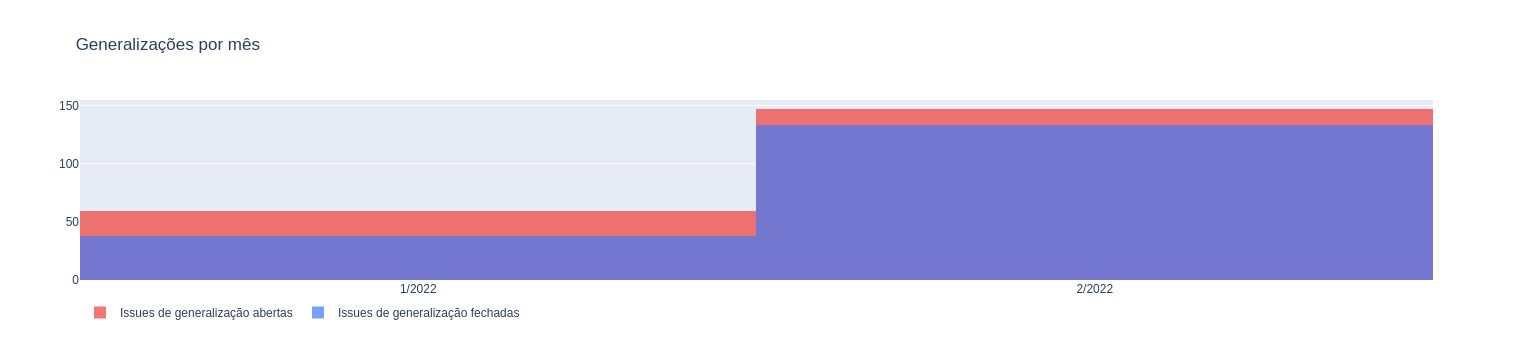

In [193]:
fig1.show()

In [239]:
open_df.to_csv("data/open_df_dev.csv", index=False)
closed_df.to_csv("data/closed_df_dev.csv", index=False)

In [240]:
closed_df.to_csv("data/closed_df_dev.csv", index=False)

In [223]:
df = info_issues_dev.merge(exploded_df, left_on='id', right_on='issues')
df = df.groupby(['template','tag', 'status'])['status'].count().unstack().reset_index().fillna(0)
df = df.sort_values('closed', ascending=False)

In [233]:
df.to_csv("data/coletas_tag_dev.csv", index=False)

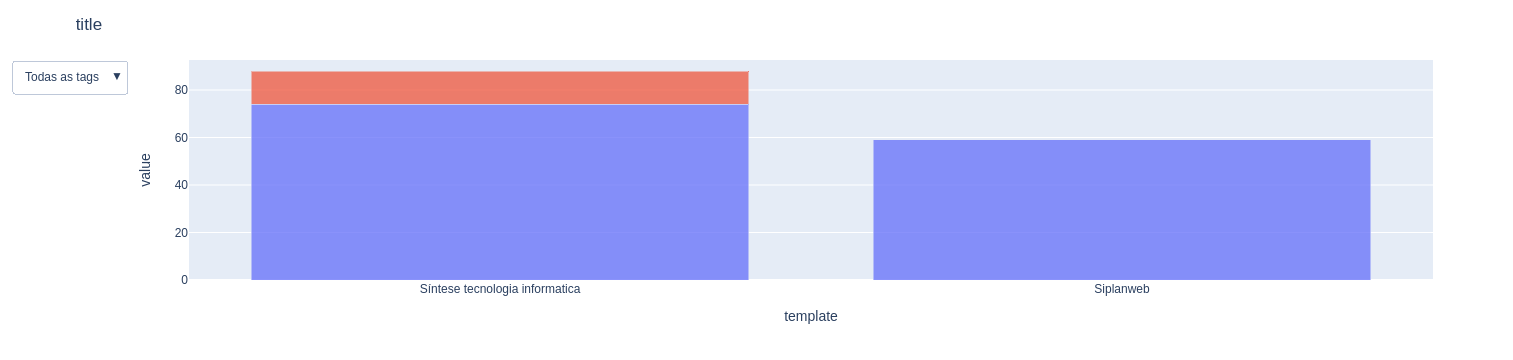

In [228]:
fig =  px.bar(df, x="template", y=["closed", "open"])

fig.update_layout(barmode='stack')

tag_list = pd.unique(df['tag']).tolist() 
buttons = []
    
buttons.append(dict(method = "restyle",
                args = [{'y': [df['closed'], df['open']], 'x': [df['template']]}],
                label = "Todas as tags"))
    
for tag in tag_list:
    aux = df.loc[df['tag'] == tag]
    
    buttons.append(dict(method = "restyle",
                args = [{'y': [aux['closed'], aux['open']], 'x':[aux['template']]},],
                label = tag))
    
fig.update_layout(autosize=True, title='title',
                  updatemenus=[dict(active=0,
                                    buttons=buttons)
                              ]) 

fig.update_traces(opacity=0.75, showlegend=False)

In [241]:
fig1, fig2 = figures.create_figures_dev()

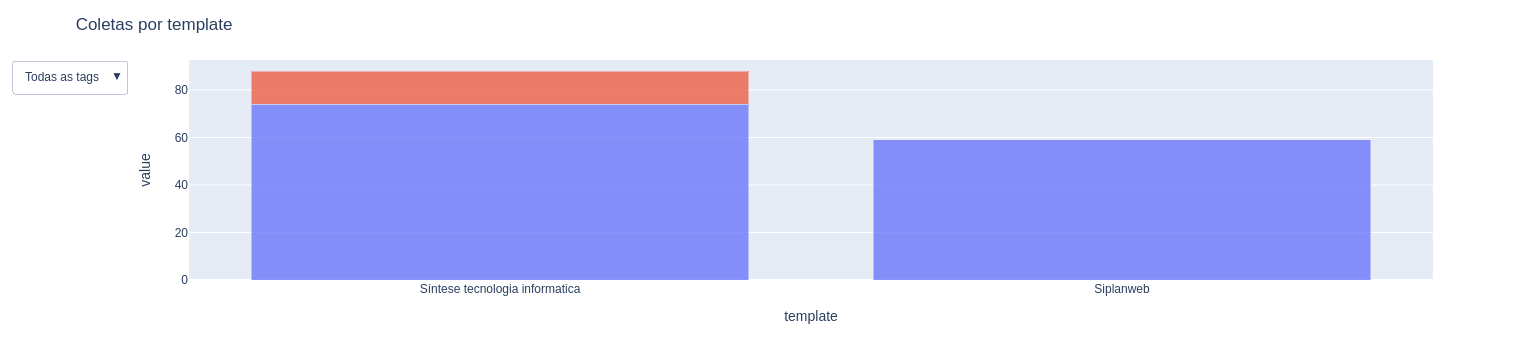

In [243]:
fig2.show()

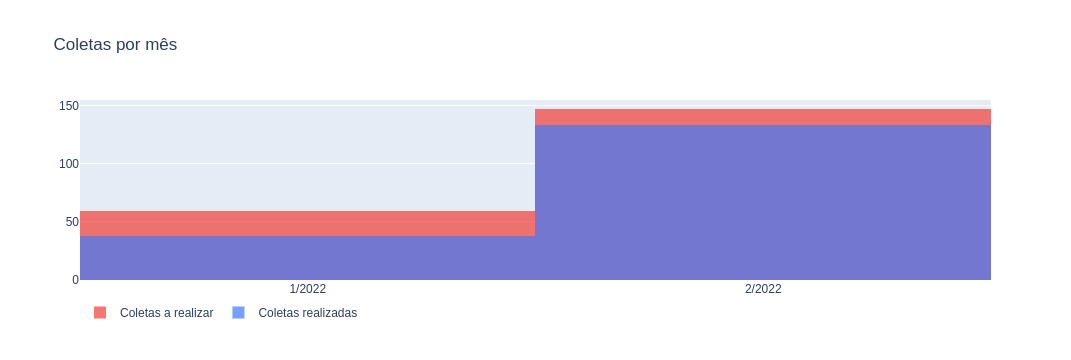

In [242]:
fig1.show()